# Part 1: setup of the cluster

In [3]:
#!pip install seaborn -q
# kill from terminal any dask that was running
!pkill -f dask-worker
!pkill -f dask-scheduler
# list all dask processes currently running (if empty we are ok)
!ps aux | grep dask-worker | grep -v grep

In [5]:
!ps aux | grep dask-scheduler | grep -v grep
!ps aux | grep dask-worker | grep -v grep


### 1.1: importing libraries

In [1]:
from dask.distributed import Client, SSHCluster, default_client, PipInstall, performance_report, wait
import dask.bag as db
import dask.dataframe as dd
import dask
import numpy as np
import json
from IPython.display import clear_output
import glob as gl
import os
import glob
from nltk.corpus import stopwords
from nltk import word_tokenize
import re
import nltk
from dask.distributed import Client
import socket
import pandas as pd
import seaborn as sns
import time

import matplotlib.pyplot as plt

### 1.2: Cluster setup

In [2]:
scheduler = "10.67.22.173" # 10.67.22.173 -- vm : mapdb-group9-2
worker1 = "10.67.22.153" # vm : mapdb-group9-2
worker2 = "10.67.22.150" # vm : mapdb-group9-3
worker3 = "10.67.22.183" # vm : mapdb-group9-4

try: ## This starts the cluster but if it was started and not closed, this will raise error, so
    cluster = SSHCluster(
        [scheduler, worker1, worker2, worker3],
        connect_options={"known_hosts": None},
        scheduler_options={"port": 8786, "dashboard_address": ":8797"},
    )
    client = Client(cluster)
except RuntimeError: # this is how to resume the cluster
    clear_output()
    client = Client(scheduler + ':8786') # restarts the cluster, by simply recalling it

display(client)



2025-07-02 12:57:37,306 - distributed.deploy.ssh - INFO - 2025-07-02 12:57:37,305 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-02 12:57:37,328 - distributed.deploy.ssh - INFO - 2025-07-02 12:57:37,327 - distributed.scheduler - INFO - State start
2025-07-02 12:57:37,332 - distributed.deploy.ssh - INFO - 2025-07-02 12:57:37,331 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.173:8786
2025-07-02 12:57:38,907 - distributed.deploy.ssh - INFO - 2025-07-02 12:57:38,906 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.153:32875'
2025-07-02 12:57:38,998 - distributed.deploy.ssh - INFO - 2025-07-02 12:57:38,998 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.150:39585'
2025-07-02 12:57:39,292 - distributed.deploy.ssh - INFO - 2025-07-02 12:57:39,290 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.1

<Client: 'tcp://10.67.22.173:8786' processes=2 threads=2, memory=7.64 GiB>

Let's check the status of the cluster. Go to the Dashboard and see if something happens

In [3]:
def who_am_i():
    import socket
    return socket.gethostname()

futures = [client.submit(who_am_i) for _ in range(10)]
results = client.gather(futures)
#print("Worker hostnames:", results)



### 1.3: Ensuring that scheduler and workers have the same python environment
We can use PipInstall Dask command to install packages across our cluster. We want to make sure that the same version of all packages is installed across them

In [4]:
plugin = PipInstall(packages=["numpy","pandas"], pip_options=["--upgrade"])
client.register_plugin(plugin)

# Part 2: setup of the data 

In [5]:
dataset_version = 30  #pr 50/ whichever we prefer
directory_path = f"data/{dataset_version}/document_parses/pdf_json/"
filenames = gl.glob(directory_path + '*.json')

print(f"Found {len(filenames)} JSON files. \n")

example = filenames[1]
with open(example, 'r') as f:
    data = json.load(f)

print('Each JSON is a dictionary with some keys:')
print(data.keys())

Found 51868 JSON files. 

Each JSON is a dictionary with some keys:
dict_keys(['paper_id', 'metadata', 'abstract', 'body_text', 'bib_entries', 'ref_entries', 'back_matter'])


### taking only a few files

In [6]:
partition_size = 200
files_to_take = len(filenames)
filenames = filenames[:files_to_take]

# function to load files
def load_json_file(path):
    with open(path) as f:
        return json.load(f)

json_bag = db.from_sequence(filenames, npartitions=partition_size).map(load_json_file)
count = json_bag.count().compute()
print('JSON bag contains',count,'files')

JSON bag contains 51868 files


# Part 3: Word counter distributed algorithm

In [7]:
en_stopwords = stopwords.words("english")

def words_in_body(body_text):

    # clean phase
    string = " ".join([txt['text'] for txt in body_text]).lower() # join all paragraphs in lowercase

    string = re.sub(r"[^a-z\s]", " ", string) # remove numbers and punctuations

    tokens = string.split() # tokenize on whitespaces (avoids words splitting)

    # remove stopwords, common words and single letters
    stop_words = set(en_stopwords) | {"fig","figure","et","al","results","also","used","using","may","one","two","de","ma","however"}
    stop_words |= set("p o i u y t r e w q l k j h g f d s a z x c v b n m".split())
    filtered_words = [w for w in tokens if w not in stop_words]

    words, words_counts = np.unique(filtered_words, return_counts=True)

    return [{"word": str(i) , "n_counts": int(j)} for i,j in zip(words,words_counts)]
    

In [8]:
# extract each document's body text
body_texts = json_bag.pluck("body_text")

# count words (map phase)
words_counts = body_texts.map(words_in_body)

# increment counters through all documents
def increment(tot, x):
    return tot + x['n_counts']

# reduce phase with foldby method
words_counted_reduce = words_counts.flatten().foldby('word', 
                                                     binop=increment, 
                                                     initial=0, 
                                                     combine = lambda x,y: x+y, 
                                                     combine_initial=0
                                                    )


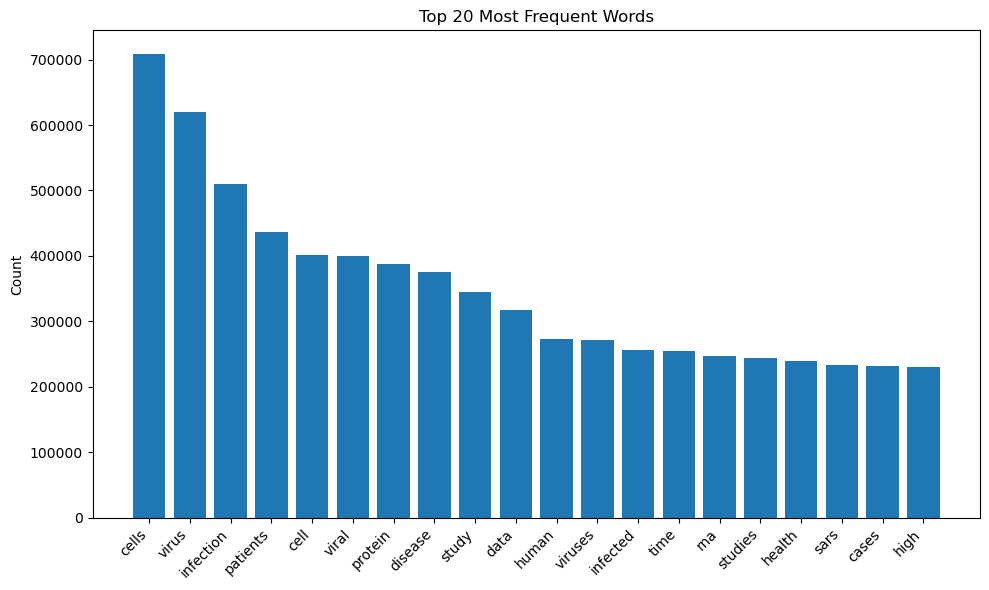

In [9]:
# Convert to a list of (word, count) tuples and compute
word_counts = words_counted_reduce.compute()

# Sort top 20 locally
sorted_words = sorted(word_counts, key=lambda x: x[1], reverse=True)[:20]

# Unzip and plot
words, counts = zip(*sorted_words)

plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Count")
plt.title("Top 20 Most Frequent Words")
plt.tight_layout()
plt.show()

# 3.1: Grid search on hyperparameters 
We want to be able to perform tasks with the highest speed possible. Hyperparameter configuration is strictly dependent on the dataset and its structure, and it's hard to infer a-priori what values they should take. For this reason, we repeat the previous analysis changing the number of available workers and the number of partitions, to see which combination performs best. We expect to have better results with 3 workers, and a number of partitions that is manageble by our workers, but at the same time that include a high number of files

In [10]:
def configuration_time(n_partitions):
    # take the starting time
    start_time = time.time()
    # configure the bag
    json_bag = db.from_sequence(filenames, npartitions=n_partitions).map(load_json_file)
    # perform the count(map phase)
    words_counts = json_bag.pluck("body_text").map(words_in_body)
    # merge the counts (reduce phase)
    words_counts_reduce = words_counts.flatten().foldby('word', 
                                                     binop=increment, 
                                                     initial=0, 
                                                     combine = lambda x,y: x+y, 
                                                     combine_initial=0
                                                    ).compute() # here we compute to really perform the operation
    end_time = time.time()
    diff_time = end_time - start_time
    print(f'With {n_partitions} partitions, computation time: {round(diff_time,2)}s')

    # delete the objects (save space)
    del json_bag
    del words_counts
    del words_counts_reduce
    
    return diff_time
    

In [26]:
client.close()
cluster.close()
# Initialize results DataFrame
df_times = pd.DataFrame(np.nan, index=partitions_list, columns=possible_workers)


In [29]:

# Parameters
partitions_list = [1,10, 20, 50, 100, 500]#[1, 5, 10, 25, 50, 100, 250, 500, 1000]
possible_workers = [1,2,3]  # Try others one at a time
chosen_n_workers = possible_workers[2]
ip_list = [scheduler, worker1, worker2, worker3]  # Assume these are defined as strings

scheduler = "10.67.22.173" # 10.67.22.173 -- vm : mapdb-group9-2
worker1 = "10.67.22.153" # vm : mapdb-group9-2
worker2 = "10.67.22.150" # vm : mapdb-group9-3
worker3 = "10.67.22.183" # vm : mapdb-group9-4

ip_list = [scheduler, worker1, worker2, worker3]

try: ## This starts the cluster but if it was started and not closed, this will raise error, so
    cluster = SSHCluster(
        ip_list[:(chosen_n_workers+1)],
        connect_options={"known_hosts": None},
        worker_options={"memory_limit":"3.8GB"},
        scheduler_options={"port": 8786, "dashboard_address": ":8797"},
    )
    client = Client(cluster)
except RuntimeError: # this is how to resume the cluster
    clear_output()
    client = Client(scheduler + ':8786') # restarts the cluster, by simply recalling it

display(client)

# Time each partition count
times_list = []
print(f'\nTrying {num_workers} workers...')
for partitions in partitions_list:
    t = configuration_time(partitions)
    times_list.append(t)

df_times[chosen_n_workers] = times_list

# Cleanup: close client and cluster explicitly
client.close()
cluster.close()

2025-07-02 23:30:58,029 - distributed.deploy.ssh - INFO - 2025-07-02 23:30:58,029 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-02 23:30:58,051 - distributed.deploy.ssh - INFO - 2025-07-02 23:30:58,051 - distributed.scheduler - INFO - State start
2025-07-02 23:30:58,055 - distributed.deploy.ssh - INFO - 2025-07-02 23:30:58,055 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.173:8786
2025-07-02 23:30:59,697 - distributed.deploy.ssh - INFO - 2025-07-02 23:30:59,699 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.150:43917'
2025-07-02 23:31:00,036 - distributed.deploy.ssh - INFO - 2025-07-02 23:31:00,041 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.153:38291'
2025-07-02 23:31:00,055 - distributed.deploy.ssh - INFO - 2025-07-02 23:31:00,057 - distributed.diskutils - INFO - Found stale lock file and directory '/

<Client: 'tcp://10.67.22.173:8786' processes=2 threads=2, memory=7.08 GiB>


Trying 2 workers...
With 1 partitions, computation time: 1073.71s
With 10 partitions, computation time: 398.48s
With 20 partitions, computation time: 420.4s
With 50 partitions, computation time: 357.93s
With 100 partitions, computation time: 377.76s
With 500 partitions, computation time: 421.53s


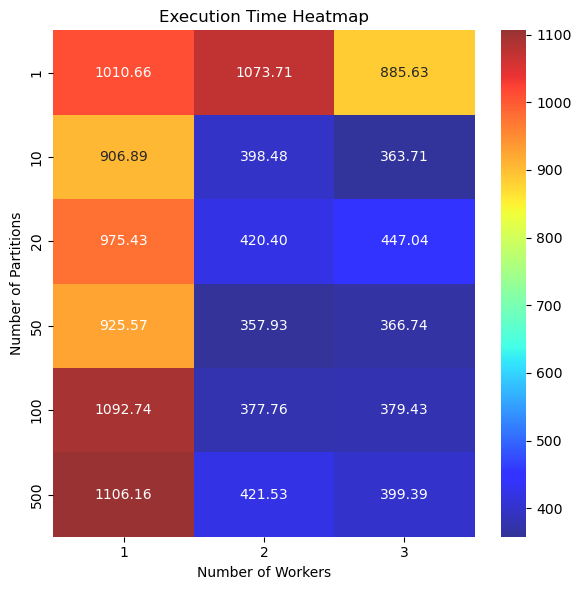

In [38]:
plt.figure(figsize=(6, 6))
sns.heatmap(final_df, annot=True, fmt=".2f", cmap="jet", alpha = 0.8)
plt.title("Execution Time Heatmap")
plt.xlabel("Number of Workers")
plt.ylabel("Number of Partitions")
plt.tight_layout()
#plt.savefig("Grid_search_execution_times.png")
plt.show()

# Dask Dashboard access
To see the Dashboard when the cluster is created: from your local machine, create an SSH tunnel forwarding the dashboard port:
```bash
ssh -L 8797:localhost:8797 -J ncognome@gate.cloudveneto.it -i ~/.ssh/chiave.pem ubuntu@10.67.22.173
```

Then open http://localhost:8797 on local browser. Note that the key must be private (chmod 600 chiave.pem) and in the gate


```bash
 ssh -L 8797:localhost:8797 -J lbrocco@gate.cloudveneto.it -i ~/.ssh/LucaKey2.pem ubuntu@10.67.22.173
```



# Ending session code
Close the cluster

In [41]:
client.close()   # disconnect client and release resources
cluster.close()  # shutdown cluster and terminate workers/scheduler
client.shutdown()

RuntimeError: IOLoop is closed